In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold
import warnings
from tqdm import tqdm_notebook
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV 


In [2]:

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from keras.utils import Sequence
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool1D, BatchNormalization,Conv1D
import tensorflow as tf
from keras import Model
# from keras.applications import ResNet50
from keras.layers import AveragePooling2D,Lambda,ReLU,MultiHeadAttention,Embedding, LeakyReLU, Concatenate
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import PowerTransformer
import tensorflow_addons as tfa
from sklearn.metrics import log_loss
from tensorflow.keras.utils import to_categorical


In [3]:
train = pd.read_csv('../input/tabular-playground-series-jun-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-jun-2021/test.csv')
subm = pd.read_csv('../input/tabular-playground-series-jun-2021/sample_submission.csv')

train.drop('id',axis=1,inplace=True)


In [4]:
print('Number of train samples %d'%train.shape[0])
print('Number of train fetures %d'%train.shape[1])
print('Number of test samples %d'%test.shape[0])
print('Number of test fetures %d'%test.shape[1])

Number of train samples 200000
Number of train fetures 76
Number of test samples 100000
Number of test fetures 76


In [5]:
train.head()

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0          0          0          6          1          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          1   
3          0          0          7          0          1          5   
4          1          0          0          0          0          0   

   feature_6  feature_7  feature_8  feature_9  ...  feature_66  feature_67  \
0          0          0          7          0  ...           0           0   
1          0          0          0          0  ...           2           0   
2          0          3          0          0  ...           0           0   
3          2          2          0          1  ...           0           4   
4          0          0          0          0  ...           0           0   

   feature_68  feature_69  feature_70  feature_71  feature_72  feature_73  \
0           0           0           0           0           2           0   
1           0           0           0           0           0           1   
2           0           0           1           0           0           0   
3           0           2           2           0           4           3   
4           0           0           0           0           0           0   

   feature_74   target  
0           0  Class_6  
1           0  Class_6  
2           0  Class_2  
3           0  Class_8  
4           0  Class_2  

[5 rows x 76 columns]

<AxesSubplot:>

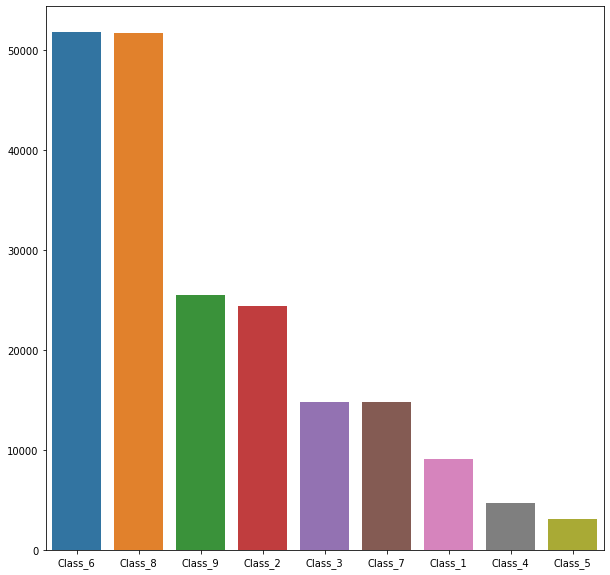

In [6]:
target_values = train['target'].value_counts().to_frame().T
plt.figure(figsize = (10,10))
sns.barplot(x = target_values.columns,y = target_values.values.reshape(-1,))

In [7]:
n_folds=5
from xgboost import XGBClassifier
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123)

from sklearn.metrics import accuracy_score, log_loss
import pickle

train['fold'] =- 1
target = train.target

for i,(train_idx,val_idx) in enumerate(skf.split(train,target)):
    train.loc[val_idx,'fold'] = i
    
train.to_csv('train_fold.csv', index=None)

# XGBoost

In [8]:
label_to_int_id = {y:x for (x,y) in enumerate(sorted(train['target'].unique()))}


In [9]:
import tensorflow


In [10]:

acc_scores = []
log_losses = []

for fold in tqdm_notebook(range(n_folds)):
    print(f'----Fold {fold}----')
    x_val, y_val = train[train['fold'] == fold].drop(['target','fold'],axis=1), train[train['fold'] == fold].target
    x_train ,y_train = train[train['fold'] != fold].drop(['target','fold'],axis=1), train[train['fold'] != fold].target
    
    y_val_num = np.array(list(map(lambda x: label_to_int_id[x], y_val)))
    y_val_cat = to_categorical(y_val_num) 
    
    model = XGBClassifier(n_estimators=1000, learning_rate=0.1, colsample_bytree=0.6, max_depth=6)
    model.fit(x_train, y_train , verbose=False, eval_set=[(x_val, y_val)], early_stopping_rounds=10)
    
    y_pred = model.predict_proba(x_val)
    
    acc = accuracy_score(y_val, model.predict(x_val))
    cce = tensorflow.keras.losses.CategoricalCrossentropy()
    logloss = cce(y_val_cat, y_pred)
    acc_scores.append(acc)
    
    log_losses.append(logloss)
    pickle.dump(model, open(f"xgb_model_{fold}.pickle.dat", "wb"))
    print(f"Fold={fold}, Accuracy={acc}")
    print(f"Fold={fold}, Loss={logloss}")
    del model
    
    
    
    

  0%|          | 0/5 [00:00<?, ?it/s]

----Fold 0----
[18:39:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold=0, Accuracy=0.3652
Fold=0, Loss=1.7457375526428223
----Fold 1----
[18:41:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold=1, Accuracy=0.3564
Fold=1, Loss=1.7556349039077759
----Fold 2----
[18:43:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold=2, Accuracy=0.35915
Fold=2, Loss=1.7540193796157837
----Fold 3----
[18:45:48] W

In [11]:
mean_val_accuracy = np.mean(acc_scores)
mean_val_loss = np.mean(log_losses)

print("Mean validation accuracy %f Mean val_loss %f "%(mean_val_accuracy, mean_val_loss))

Mean validation accuracy 0.361430 Mean val_loss 1.751033 


# CatBoost

In [12]:
import catboost
from catboost import CatBoostClassifier

catb_model = CatBoostClassifier(iterations=1000, loss_function='MultiClass', early_stopping_rounds = 20, eval_metric = 'MultiClass', learning_rate = 0.1 )

acc_scores = []
log_losses = []
for fold in tqdm_notebook(range(n_folds)):
    x_val, y_val = train[train['fold'] == fold].drop(['target','fold'],axis=1), train[train['fold'] == fold].target
    x_train ,y_train = train[train['fold'] != fold].drop(['target','fold'],axis=1), train[train['fold'] != fold].target
    
    y_val_num = np.array(list(map(lambda x: label_to_int_id[x], y_val)))
    y_val_cat = to_categorical(y_val_num) 

    
    catb_model.fit(x_train, y_train, eval_set=(x_val, y_val), verbose = False, plot = True)
    y_pred = catb_model.predict_proba(x_val)
    
    acc = accuracy_score(y_val, catb_model.predict(x_val))
    acc_scores.append(acc)
    
    cce = tensorflow.keras.losses.CategoricalCrossentropy()
    logloss = cce(y_val_cat, y_pred)
    log_losses.append(logloss)
    
    catb_model.save_model(f"catb_model_{fold}.bin")
    print(f"Fold={fold}, Accuracy={acc}")
    print(f"Fold={fold}, Loss={logloss}")


  0%|          | 0/5 [00:00<?, ?it/s]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold=0, Accuracy=0.36525
Fold=0, Loss=1.7439517974853516


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold=1, Accuracy=0.35655
Fold=1, Loss=1.7537142038345337


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold=2, Accuracy=0.35995
Fold=2, Loss=1.750758171081543


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold=3, Accuracy=0.362625
Fold=3, Loss=1.7469837665557861


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold=4, Accuracy=0.3641
Fold=4, Loss=1.7460105419158936


In [13]:
mean_val_accuracy = np.mean(acc_scores)
mean_val_loss = np.mean(log_losses)

print("Mean validation accuracy %f Mean val_loss %f "%(mean_val_accuracy, mean_val_loss))

Mean validation accuracy 0.361695 Mean val_loss 1.748284 


# Neural Net

In [14]:
def nn_model():
    inputs = Input(shape = (75,))
    
    embed = Embedding(360, 8)(inputs)
    embed = Flatten()(embed)
    
    hidden = Dropout(0.2)(embed)
    hidden = tfa.layers.WeightNormalization(Dense(units=32, activation='selu', kernel_initializer="lecun_normal"))(hidden)
    
    output = Dropout(0.2)(Concatenate()([embed, hidden]))
    output = tfa.layers.WeightNormalization(Dense(units=32, activation='relu'))(output) 
    
    output = Dropout(0.3)(Concatenate()([embed, hidden, output]))
    output = tfa.layers.WeightNormalization(Dense(units=32, activation='elu'))(output) 
    output = Dense(9, activation = 'softmax')(output)
    
    model = Model(inputs=inputs, outputs=output, name="res_nn_model")
    
    return model

In [15]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-05, patience=8, verbose=0,
    mode='min', baseline=None, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

In [16]:
from copy import deepcopy
train1 = deepcopy(train)

label_to_id_dict = {label:no for (no,label) in enumerate(sorted(train1['target'].unique()))}
train1['target'] = train1['target'].map(label_to_id_dict)

In [17]:
acc_scores = []
log_losses = []

for fold in tqdm_notebook(range(n_folds)):
    print(f'----Fold {fold}----')
    x_val, y_val = train1[train1['fold'] == fold].drop(['target','fold'], axis=1).values,\
                    train1[train1['fold'] == fold].target.values
    x_train ,y_train = train1[train1['fold'] != fold].drop(['target','fold'], axis=1).values, \
                        train1[train1['fold'] != fold].target.values

    
    
    y_val_cat = to_categorical(y_val) 

    
        
    model = nn_model()
    
    opt = Adam(learning_rate=0.001)
    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
    
    model.compile(opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'./nn_model_{fold}.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=256, callbacks=[es, reduce_lr, model_checkpoint_callback])
    
    y_pred = model.predict(x_val)
    y_pred_labels = [np.argmax(arr) for arr in y_pred]
    
    acc = accuracy_score(y_val, y_pred_labels)
    acc_scores.append(acc)
    
    cce = tensorflow.keras.losses.CategoricalCrossentropy()
    logloss = cce(y_val_cat, y_pred)
    log_losses.append(logloss)
    

    
    print(f"Fold={fold}, Accuracy={acc}")
    print(f"Fold={fold}, Loss={logloss}")
    del model
    
    
    
    

  0%|          | 0/5 [00:00<?, ?it/s]

----Fold 0----
(160000, 75) (160000,) (40000, 75) (40000,)
Epoch 1/50
625/625 [==============================] - 8s 11ms/step - loss: 1.8305 - accuracy: 0.3311 - val_loss: 1.7483 - val_accuracy: 0.3636

Epoch 00001: val_loss improved from inf to 1.74825, saving model to ./nn_model_0.h5
Epoch 2/50
625/625 [==============================] - 6s 10ms/step - loss: 1.7549 - accuracy: 0.3589 - val_loss: 1.7445 - val_accuracy: 0.3652

Epoch 00002: val_loss improved from 1.74825 to 1.74452, saving model to ./nn_model_0.h5
Epoch 3/50
625/625 [==============================] - 6s 10ms/step - loss: 1.7485 - accuracy: 0.3613 - val_loss: 1.7420 - val_accuracy: 0.3650

Epoch 00003: val_loss improved from 1.74452 to 1.74200, saving model to ./nn_model_0.h5
Epoch 4/50
625/625 [==============================] - 6s 10ms/step - loss: 1.7503 - accuracy: 0.3591 - val_loss: 1.7434 - val_accuracy: 0.3659

Epoch 00004: val_loss did not improve from 1.74200
Epoch 5/50
625/625 [==============================] - 

In [18]:
mean_val_accuracy = np.mean(acc_scores)
mean_val_loss = np.mean(log_losses)

print("Mean validation accuracy %f Mean val_loss %f "%(mean_val_accuracy, mean_val_loss))

Mean validation accuracy 0.362265 Mean val_loss 1.744394 


In [19]:
submission_df = pd.DataFrame(columns=['ID','Class_1','Class_2','Class_3','Class_4','Class_5','Class_6','Class_7','Class_8','Class_9'])
xg_df = pd.DataFrame(columns=['ID','Class_1','Class_2','Class_3','Class_4','Class_5','Class_6','Class_7','Class_8','Class_9'])
cat_df = pd.DataFrame(columns=['ID','Class_1','Class_2','Class_3','Class_4','Class_5','Class_6','Class_7','Class_8','Class_9'])
nn_df = pd.DataFrame(columns=['ID','Class_1','Class_2','Class_3','Class_4','Class_5','Class_6','Class_7','Class_8','Class_9'])


probs_xg = 0
for fold in range(n_folds):
    xgb_model = pickle.load(open(f"xgb_model_{fold}.pickle.dat", "rb"))
    probs_xg += xgb_model.predict_proba(test.drop('id', axis=1))

probs_cat= 0
for fold in range(n_folds):
    
    
    cat_model = catb_model.load_model(f"catb_model_{fold}.bin")
    probs_cat += cat_model.predict_proba(test.drop('id', axis=1))
    
probs_nn = 0
for fold in range(n_folds):
    nn_model = tf.keras.models.load_model(f"nn_model_{fold}.h5")
    
    probs_nn += nn_model.predict(test.drop('id', axis=1))


    
xg_df['ID'] = test.id.tolist()
xg_df[['Class_1','Class_2','Class_3','Class_4','Class_5','Class_6','Class_7','Class_8','Class_9']] = probs_xg/n_folds
cat_df['ID'] = test.id.tolist()
cat_df[['Class_1','Class_2','Class_3','Class_4','Class_5','Class_6','Class_7','Class_8','Class_9']] = probs_cat/n_folds
nn_df['ID'] = test.id.tolist()
nn_df[['Class_1','Class_2','Class_3','Class_4','Class_5','Class_6','Class_7','Class_8','Class_9']] = probs_nn/n_folds
    

# submission_df['id'] = test.id.values
# submission_df[['class_1','class_2','class_3','class_4','class_5','class_6','class_7','class_8','class_9']] = (probs_xg + probs_cat + probs_nn)/(3*n_folds)

    

In [20]:
# submission_df.to_csv('submission.csv',index=None)
cat_df.to_csv('cat.csv',index=None)
xg_df.to_csv('xg.csv',index=None)
nn_df.to_csv('nn.csv',index=None)


In [21]:
def generate(main, support, coeff):
    
    g = main.copy()    
    for i in main.columns[1:]:
        
        res = []
        lm, Is = [], []        
        lm = main[i].tolist()
        ls = support[i].tolist()  
        
        for j in range(len(main)):
            res.append((lm[j] * coeff) + (ls[j] * (1.- coeff)))            
        g[i] = res
        
    return g

In [22]:
sub4 = pd.read_csv('../input/tabular-residual-network/submission.csv')
sub4.to_csv("submission4.csv",index=False)

In [23]:
sub5 = pd.read_csv('../input/tps-june-21-eda-models/Solution.csv')
sub5.to_csv("submission5.csv",index=False)

In [24]:
sub6 = pd.read_csv('../input/tps6-74442/TPS6_74442.csv')
sub6.to_csv("submission6.csv",index=False)

In [25]:
sub7 = pd.read_csv('../input/tps06-nns-gbts-optimization/submission.csv')
sub7.to_csv("submission7.csv",index=False)

In [26]:
sub8 = pd.read_csv('../input/3-tps-jun-21-smart-ensembling-for-classifier/submission_ens.csv')
sub8.to_csv("submission8.csv",index=False)

In [27]:
sub = generate(cat_df, xg_df, 0.85)

sub = generate(nn_df, sub , 0.85)

sub = generate(sub4, sub , 0.85)

sub = generate(sub5, sub , 0.85)

sub = generate(sub6, sub , 0.55)

sub = generate(sub7, sub , 0.85)

sub = generate(sub8, sub , 0.85)


In [28]:
sub.to_csv("submission.csv",index=False)